# M1 useful nodes
This notebook identifies M1 nodes (attention heads and MLPs) that, when ablated, cause a decrease in model prediction accuracy. These nodes are needed (aka useful) for accurate predictions.


This notebook was:
- Developed on Google Colab using an **T4**
- Runs with M1 (TinyStories) with base/CS1/CS2/CS3.
- Requires a GITHUB_TOKEN secret to access Martian TinySQL code repository.
- Requires a HF_TOKEN secret to access Martian HuggingFace repository.

This notebook relies on the nnsight library. Useful background:
- https://nnsight.net/notebooks/tutorials/walkthrough/#Batching
- https://nnsight.net/notebooks/tutorials/walkthrough/#Looping

This notebook relies on the https://github.com/PhilipQuirke/quanta_mech_interp library for graphing useful nodes.

# Import libraries
Imports standard libraries. Do not read.

In [1]:
# https://nnsight.net/
# Access 0.4 prerelease version (as at Dec 2024)
#!pip install nnsight==0.4.0.dev0
!pip install -U nnsight

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 8.0 MB/s eta 0:00:00


In [2]:
from IPython.display import clear_output
import einops
import torch
import numpy as np
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "colab"
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

import nnsight
from nnsight import LanguageModel

In [3]:
from getpass import getpass
from google.colab import userdata
import gc
import weakref

In [4]:
!pip install --upgrade git+https://github.com/PhilipQuirke/quanta_mech_interp.git
import QuantaMechInterp as qmi

  Cloning https://github.com/PhilipQuirke/quanta_mech_interp.git to /tmp/pip-req-build-v8v6f09p
  Running command git clone --filter=blob:none --quiet https://github.com/PhilipQuirke/quanta_mech_interp.git /tmp/pip-req-build-v8v6f09p
  Resolved https://github.com/PhilipQuirke/quanta_mech_interp.git to commit f62ff56a10011bc66c119d14314c26ff2fd36491
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of torchtyping to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.1 MB/s eta 0:00:00
  Created wheel for QuantaMechInterp: filename=QuantaMechInterp-1.0-py3-none-any.whl size=39847 sha256=27d0ec94e94e090bbd894afbe03c7b59bd8815c5a4737e46e4647ca5b15d668f
  Stored in directory: /tmp/pip-ephem-wheel-cache-c7fbhcz9/wheels/0f/d1/c3/1763b9cf263825f6202103985dba1535762cf43b87d

In [5]:
github_token = userdata.get("GITHUB_TOKEN")

# Install the private repository using the token
!pip install --upgrade git+https://{github_token}@github.com/withmartian/TinySQL.git

import TinySQL as qts

  Cloning https://****@github.com/withmartian/TinySQL.git to /tmp/pip-req-build-vex76q_g
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/withmartian/TinySQL.git' /tmp/pip-req-build-vex76q_g
  Resolved https://****@github.com/withmartian/TinySQL.git to commit cd1fbe1ea5a9223bc415dec0059e641c582a202e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for TinySQL: filename=TinySQL-1.0-py3-none-any.whl size=43302 sha256=5267b4ee76d2fa2e1be73581a4b27d98d9620fa1792c52353a24456b202d4025
  Stored in directory: /tmp/pip-ephem-wheel-cache-rrphu5wl/wheels/10/be/48/fbfe43d18ecb23d7ab63402c14e8f023c4e04b3896e7652b03
Successfully built TinySQL


# Select model, command set and feature to investigate


In [6]:
model_num = 1                 # 1=TinyStories, 2=Qwen, 3=Llama, 4=Granite, 5=SmolLM
cs_num = 1                    # 0=BaseModel, 1=CS1, 2=CS2 or 3=CS3

# Load model

In [7]:
model = qts.load_tinysql_model(model_num, cs_num, auth_token=userdata.get("HF_TOKEN"))
clear_output()
print(model)

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50258, 1024)
    (wpe): Embedding(2048, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPTNeoBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
          (c_proj): L

In [8]:
N_LAYERS, N_HEADS, D_MODEL, D_HEAD = qts.get_model_sizes(model_num, model)

N_LAYERS=2 N_HEADS=16 D_MODEL=1024 D_HEAD=64


In [9]:
model_hf_name = qts.sql_interp_model_location(model_num, cs_num)

# Singleton QuantaTool "main" configuration class. qmi.AlgoConfig is derived from the chain qmi.UsefulConfig > qmi.ModelConfig
cfg = qmi.AlgoConfig()
cfg.repo_name, cfg.model_name = model_hf_name.rsplit("/", 1)
cfg.main_model = model
cfg.n_layers = N_LAYERS
cfg.n_heads = N_HEADS
cfg.d_model = D_MODEL
cfg.d_head = D_HEAD
cfg.file_config_prefix = ""

print("cfg.repo_name="+cfg.repo_name, "cfg.model_name="+cfg.model_name)

cfg.repo_name=withmartian cfg.model_name=sql_interp_bm1_cs1_experiment_1.6


# Generate test data and experiment runs

In [10]:
# Generate a batch of prompts with 3 field names
def generate_batch(batch_size):
    cfg.batch_size = batch_size

    return qts.generate_csn(batch_size=batch_size, csn=max(1,cs_num), min_cols=3, max_cols=3)

In [11]:
def run_attention_experiment(run_layer_idx, run_head_idx, run_token_idx, all_tokens, run_prompt_tokens, run_generate, make_changes = True):

    assert len(all_tokens) == run_prompt_tokens + run_generate

    if run_generate == 0:
        return True, "", ""

    start = run_head_idx * D_HEAD
    end = (run_head_idx + 1) * D_HEAD

    with model.generate(all_tokens[:run_prompt_tokens], max_new_tokens=run_generate, pad_token_id=model.tokenizer.eos_token_id):

        if make_changes:
            model.transformer.h[run_layer_idx].output[0][:, run_token_idx, start:end] = 0

        final_output = model.generator.output.save()

    # Did the output change?
    decoded_input = model.tokenizer.decode(all_tokens, skip_special_tokens=True)
    decoded_output = model.tokenizer.decode(final_output[0], skip_special_tokens=True)
    same = decoded_input==decoded_output

    return same, decoded_input, decoded_output

In [12]:
# Return a list of experiments to run
def get_experiment_list(examples, by_attention_head):
    run_list = []
    max_prompt_tokens = 0
    max_answer_tokens = 0
    max_tokens = 0
    show_one_example = True

    for example in examples:
        prompt = example.get_alpaca_prompt()
        answer = example.sql_statement

        prompt_tokens = model.tokenizer(prompt)["input_ids"]
        answer_tokens = model.tokenizer(answer)["input_ids"]
        all_tokens = prompt_tokens + answer_tokens

        num_answer_tokens = len(answer_tokens)
        num_prompt_tokens = len(prompt_tokens)
        num_tokens = len(all_tokens)
        assert num_tokens == num_prompt_tokens + num_answer_tokens

        max_prompt_tokens = max(max_prompt_tokens, num_prompt_tokens)
        max_answer_tokens = max(max_answer_tokens, num_answer_tokens)
        max_tokens = max(max_tokens, num_tokens)

        # Check that the model can predict the question
        same, _, decoded_output = run_attention_experiment(0, 0, 0, all_tokens, num_prompt_tokens, num_answer_tokens, make_changes = False)
        if not same:
            print( "Ignoring example that model doesn't predict correctly:", prompt.replace('\n', ' '), answer.replace('\n', ' ') )
            continue
        elif show_one_example:
            print("Example model predict correctly:", prompt.replace('\n', ' '), answer.replace('\n', ' ') )
            show_one_example = False;

        if by_attention_head:
            for layer_idx in range(N_LAYERS):
                for head_idx in range(N_HEADS):
                    for token_idx in range(num_tokens):
                        exp_prompt_tokens = max(num_prompt_tokens, token_idx+1)
                        exp_num_generate = num_tokens - exp_prompt_tokens

                        assert num_tokens == exp_prompt_tokens + exp_num_generate

                        run_list.append([layer_idx, head_idx, token_idx, all_tokens, exp_prompt_tokens, exp_num_generate])
        else:
            for token_idx in range(num_prompt_tokens):
                run_list.append([prompt, answer, token_idx, prompt_tokens])

    return run_list, max_prompt_tokens, max_answer_tokens, max_tokens

# Which token positions are useful?
This information is used to shrink the size of search spaces in following sections. For the SQL model all token positions are useful

In [23]:
N_BATCH = 50

def run_token_experiments( ):
    examples = generate_batch(N_BATCH)
    run_list, max_prompt_tokens, max_good_answer_tokens, max_tokens = get_experiment_list(examples, False)
    cfg.initialize_token_positions( max_prompt_tokens, max_good_answer_tokens, True )
    num_exps = len(run_list)

    print("N_BATCH="+str(N_BATCH), "max_prompt_tokens="+str(max_prompt_tokens), "max_good_answer_tokens="+str(max_good_answer_tokens), "max_tokens="+str(max_tokens), "num_exps="+str(num_exps))

    try_results = np.zeros(max_tokens, dtype=int)
    fail_results = np.zeros(max_tokens, dtype=int)

    for item_num in tqdm.tqdm(range(num_exps)):

        run_item = run_list[item_num]
        run_prompt, run_answer, run_token_idx, prompt_tokens = run_item

        with model.generate(prompt_tokens, max_new_tokens=max_good_answer_tokens, pad_token_id=model.tokenizer.eos_token_id) :

            # Zero out just the portion of the output corresponding to this token position
            for run_layer_idx in range(N_LAYERS):
                model.transformer.h[run_layer_idx].output[0][:, run_token_idx, :] = 0

            final_output = model.generator.output.save()

        #final_output = final_output.detach().cpu().numpy()
        decoded_output = model.tokenizer.decode(final_output[0], skip_special_tokens=True)

        # Did the output change?
        if run_prompt + run_answer != decoded_output:
            fail_results[run_token_idx] += 1
        try_results[run_token_idx] += 1

    # Compute the failure rate as percentage
    failure_rate = (1.0 * fail_results / (try_results + 1e-10)) * 100
    failure_rate = np.round(failure_rate, 2)

    return max_tokens, fail_results, failure_rate

g_max_tokens, g_token_fail_results, g_token_failure_rate = run_token_experiments()

Example model predict correctly: ### Instruction: Could you show me permissions and last_login from performance_logs? ### Context: CREATE TABLE performance_logs (      permissions TEXT,     task_id INTEGER,     last_login DATETIME  ) ### Response:  SELECT     permissions,     last_login FROM performance_logs
N_BATCH=50 max_prompt_tokens=82 max_good_answer_tokens=30 max_tokens=112 num_exps=3185


  0%|          | 0/3185 [00:00<?, ?it/s]

In [24]:
print( "Useful token positions:" )
for token_idx in range(len(g_token_failure_rate)):
    if g_token_failure_rate[token_idx] > 0 :
        cfg.add_useful_position(token_idx)
        print( "Position:", token_idx, "    % Fails:", g_token_failure_rate[token_idx], "    # Fails:", g_token_fail_results[token_idx] )

Useful token positions:
Position: 4     % Fails: 2.0     # Fails: 1
Position: 5     % Fails: 22.0     # Fails: 11
Position: 6     % Fails: 32.0     # Fails: 16
Position: 7     % Fails: 18.0     # Fails: 9
Position: 8     % Fails: 24.0     # Fails: 12
Position: 9     % Fails: 18.0     # Fails: 9
Position: 10     % Fails: 44.0     # Fails: 22
Position: 11     % Fails: 40.0     # Fails: 20
Position: 12     % Fails: 42.0     # Fails: 21
Position: 13     % Fails: 24.0     # Fails: 12
Position: 14     % Fails: 18.0     # Fails: 9
Position: 15     % Fails: 10.0     # Fails: 5
Position: 16     % Fails: 8.0     # Fails: 4
Position: 17     % Fails: 6.0     # Fails: 3
Position: 19     % Fails: 6.0     # Fails: 3
Position: 20     % Fails: 4.0     # Fails: 2
Position: 21     % Fails: 8.0     # Fails: 4
Position: 22     % Fails: 4.0     # Fails: 2
Position: 24     % Fails: 4.0     # Fails: 2
Position: 25     % Fails: 4.0     # Fails: 2
Position: 26     % Fails: 6.0     # Fails: 3
Position: 27     % 

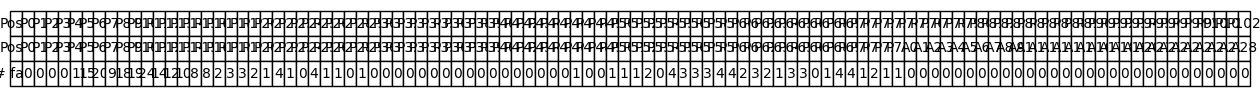

In [16]:
cfg.calc_position_failures_map(g_token_fail_results.tolist())
qmi.save_plt_to_file(cfg=cfg, full_title="Failures When Position Ablated")
plt.show()

# Which token+layer+attention head nodes are useful?

In [17]:
N_BATCH = 10

def run_attention_experiments():
    show_diff = True
    examples = generate_batch(N_BATCH)
    run_list, max_prompt_tokens, max_good_answer_tokens, max_tokens = get_experiment_list(examples, True)
    num_exps = len(run_list)

    print("N_BATCH="+str(N_BATCH), "max_prompt_tokens="+str(max_prompt_tokens), "max_answer_tokens="+str(max_good_answer_tokens), "max_tokens="+str(max_tokens), "num_exps="+str(num_exps))

    try_results = np.zeros((N_LAYERS, N_HEADS, max_tokens), dtype=int)
    fail_results = np.zeros((N_LAYERS, N_HEADS, max_tokens), dtype=int)

    for item_num in tqdm.tqdm(range(num_exps)):

        run_item = run_list[item_num]
        run_layer_idx, run_head_idx, run_token_idx, all_tokens, num_prompt_tokens, num_generate = run_item

        same, decoded_input, decoded_output = run_attention_experiment(run_layer_idx, run_head_idx, run_token_idx, all_tokens, num_prompt_tokens, num_generate)

        if not same:
            fail_results[run_layer_idx, run_head_idx, run_token_idx] += 1
            if show_diff:
                print("Failure when intervening", run_layer_idx, run_head_idx, run_token_idx, num_prompt_tokens, num_generate)
                print("Input :", decoded_input.replace('\n', ' '))
                print("Output:", decoded_output.replace('\n', ' '))
                show_diff = False
        try_results[run_layer_idx, run_head_idx, run_token_idx] += 1


    # Compute the failure rate as percentage
    failure_rate = (1.0 * fail_results / (try_results + 1e-10)) * 100
    failure_rate = np.round(failure_rate, 2)

    return max_tokens, fail_results, failure_rate, try_results

g_max_tokens, g_attn_failure_results, g_attn_failure_rate, g_attn_try_results = run_attention_experiments()

Example model predict correctly: ### Instruction: Run a query for tags in group_members ### Context: CREATE TABLE group_members (      mac_address CHAR(17),     tags VARCHAR(500),     address_line1 VARCHAR(255)  ) ### Response:  SELECT tags FROM group_members
N_BATCH=10 max_prompt_tokens=70 max_answer_tokens=21 max_tokens=91 num_exps=24576


  0%|          | 0/24576 [00:00<?, ?it/s]

Failure when intervening 0 8 8 69 6
Input : ### Instruction: Run a query for tags in group_members ### Context: CREATE TABLE group_members (      mac_address CHAR(17),     tags VARCHAR(500),     address_line1 VARCHAR(255)  ) ### Response: SELECT tags FROM group_members
Output: ### Instruction: Run a query for tags in group_members ### Context: CREATE TABLE group_members (      mac_address CHAR(17),     tags VARCHAR(500),     address_line1 VARCHAR(255)  ) ### Response: SELECT mac_address FROM group


In [18]:
cfg.useful_nodes = qmi.UsefulNodeList()
for layer_idx in range(N_LAYERS):
    for head_idx in range(N_HEADS):
        for token_idx in range(g_max_tokens):
            fail_perc = int(g_attn_failure_rate[layer_idx, head_idx, token_idx])
            if fail_perc > 0 :
                # Add percentage failure quanta
                node_location = qmi.NodeLocation(token_idx, layer_idx, True, head_idx)
                cfg.add_useful_node_tag( node_location, qmi.QType.FAIL.value, str(fail_perc) )

cfg.useful_nodes.sort_nodes()

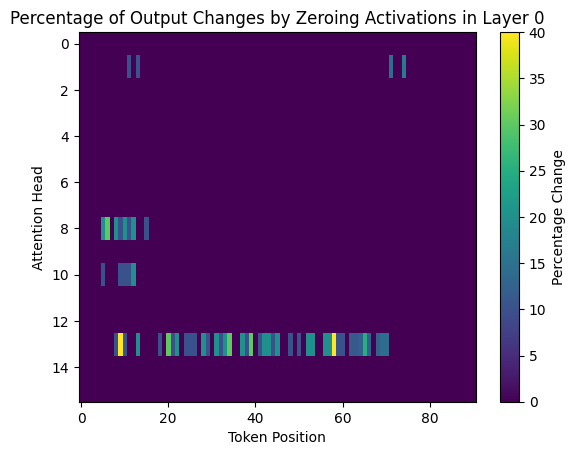

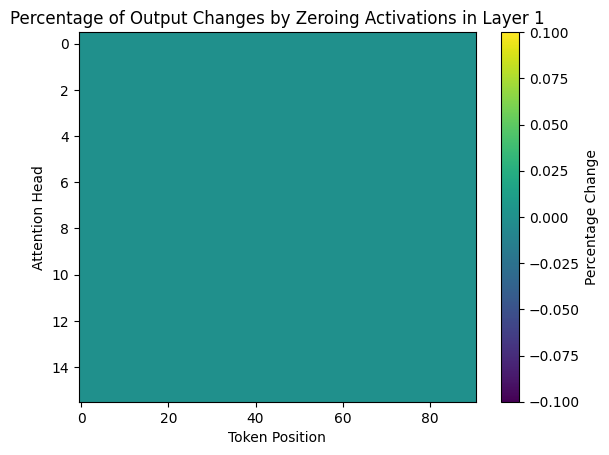

In [19]:
for layer_idx in range(N_LAYERS):
    plt.imshow(g_attn_failure_rate[layer_idx], cmap="viridis", aspect="auto")
    plt.colorbar(label="Percentage Change")
    plt.xlabel("Token Position")
    plt.ylabel("Attention Head")
    plt.title("Percentage of Output Changes by Zeroing Activations in Layer " + str(layer_idx))
    plt.show()

In [20]:
# cfg.useful_nodes.print_node_tags()

Saving quanta map: Useful attention heads


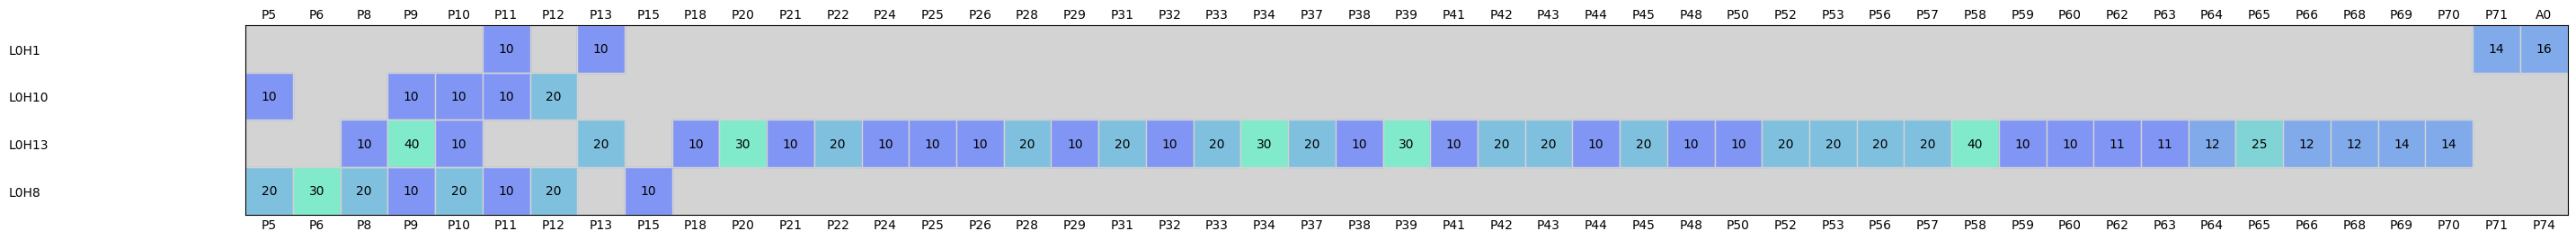

In [21]:
title = "Useful attention heads"
ax1, quanta_results, num_results = qmi.calc_quanta_map(
    cfg, True, 6,
    cfg.useful_nodes, qmi.QType.FAIL.value, "", qmi.get_quanta_fail_perc,
    combine_identical_cells=False)

if num_results > 0:
    if cfg.graph_file_suffix > "":
        print("Saving quanta map:", title)
        qmi.save_plt_to_file(cfg=cfg, full_title=title)
    else:
        ax1.set_title(title + ' ({} nodes)'.format(len(quanta_results)))

    plt.show()

In [22]:
# Serialize and save the useful nodes list to a temporary CoLab file in JSON format
main_fname_behavior_json = cfg.model_name + '_behavior.json'
print( "Saving useful node list with behavior tags:", main_fname_behavior_json)
cfg.useful_nodes.save_nodes(main_fname_behavior_json)

Saving useful node list with behavior tags: sql_interp_bm1_cs1_experiment_1.6_behavior.json
